In [1]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage


Populating the interactive namespace from numpy and matplotlib


In [2]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data1/v45/pas561/mom/archive/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print geolon_t.shape

fh=fcor/ht
print fh.shape

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print st_ocean.shape
print potrho.shape
print yt_ocean.shape


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [10]:
UpDir='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080_UP/'
Ocean_File = os.path.join(UpDir,'output5*/ocean.nc')
#Ocean_File = os.path.join(UpDir)
print Ocean_File
ff=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print ff.tx_trans.shape
up_bsf=ff.tx_trans[:,:,:,:].mean('time').sum('st_ocean').cumsum('yt_ocean')
print up_bsf.shape

#of=os.path.join(UpDir,'bsf_550to559.npy')
#a=np.save(of,up_bsf)


/g/data3/hh5/tmp/pas561/gfdl_nyf_1080_UP/output5*/ocean.nc
(5, 50, 1080, 1440)
(1080, 1440)


In [25]:
#now find DP transport to subtract for the NAtl psi - see Rong

# do psi max between lon 67-69S
i1=np.argwhere(xt_ocean<-69)
i2=np.argwhere(xt_ocean<-67)
i1=i1[-1]
i2=i2[-1]

j1=np.argwhere(yt_ocean<-54)
j1=j1[-1]

print j1, i1, i2

up_dp = up_bsf[0:j1,i1:i2]
print up_dp.shape
up_dp_bar = np.mean(up_dp,1)
print up_dp_bar.shape
print up_dp_bar[0]
#up_dp_ts = np.max(up_dp_bar,0)
#print 'here',up_dp_ts[0]

[239] [843] [851]
(239, 8)
(239,)
<xarray.DataArray 'tx_trans' ()>
dask.array<shape=(), dtype=float32, chunksize=()>
Coordinates:
    yt_ocean  float64 -81.08


[-200. -180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.
   40.   60.   80.  100.  120.  140.  160.  180.  200.]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.01/lib/python2.7/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[  0  20  40  60  80 100 120 140 160 180]


NameError: name 'cntrl_psi' is not defined

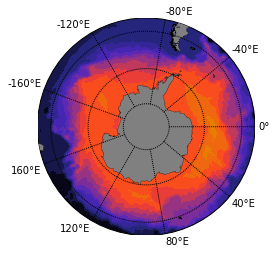

In [26]:
#plot ACC transport
levels = np.linspace(-200,200,21)
print levels

plt.subplot(1,1,1)
map = Basemap(projection='spstere',boundinglat=-45,lon_0=90,resolution='l',round=True)
map.drawcoastlines(linewidth=0.25)
map.fillcontinents(color='gray',lake_color='gray')
# draw parallels and meridians.
map.drawparallels(np.arange(-80.,81.,15.))
map.drawmeridians(np.arange(-160.,181.,40.),labels=[True,True,True,True])
X, Y = map(geolon_t,geolat_t) 
p1=map.contourf(X,Y,up_bsf, cmap=plt.cm.CMRmap_r, levels=levels, extend='both') #CMRmap_r, gist_stern_r
clev3 = np.arange(0,200,20)
print clev3
map.contour(X,Y,cntrl_psi,levels=clev3,colors='g',linewidths=1)
plt.title('psi')

ax3 = plt.axes([0.92,0.38,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('UP BSF Transport (Sv)')